In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as ss

from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, roc_auc_score,auc,roc_curve
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier


In [2]:
def evaluate_model(classifier, X_test, y_test, model_name):
  y_pred = classifier.predict(X_test)
  y_pred_prob = classifier.predict_proba(X_test)
  
  sensibilidad = recall_score(y_test, y_pred)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_prob[:,1])
  roc_auc = auc(false_positive_rate, true_positive_rate)
  gini = 2 * roc_auc - 1
  
  return {
      'Modelo': model_name,
      'Sensibilidad': sensibilidad,
      'ROC': roc_auc,
      'GINI': gini
  }


In [3]:
resultados = []
sc = StandardScaler()
sm = SMOTE(random_state=0)
ros = RandomOverSampler(random_state=0)
rus = RandomUnderSampler(random_state=0)

# Levantamiento y separación de los datos

In [4]:
data = pd.read_csv('datos/Social_Network_Ads.csv')
data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [5]:
data.dtypes

User ID             int64
Gender             object
Age                 int64
EstimatedSalary     int64
Purchased           int64
dtype: object

In [6]:
ss.shapiro(data['Age'])

ShapiroResult(statistic=0.9785022735595703, pvalue=1.1644284313661046e-05)

In [7]:
ss.shapiro(data['EstimatedSalary'])

ShapiroResult(statistic=0.9600138068199158, pvalue=5.734485331032602e-09)

Con una confianza del 95%, la variable 'Age' no se aproxima a una distribución normal, pues el p-valor es < 5%.

Con una confianza del 95%, la variable 'EstimatedSalary' tampoco se aproxima a una distribución normal, dado que su p-valor es < 5%.

Ambas variables, a pesar de tener estadísticas que sugieren cierta similitud con una distribución normal, tienen valores p que indican lo contrario con un nivel de confianza del 95%. Por lo tanto, deberíamos considerar que no se distribuyen normalmente.

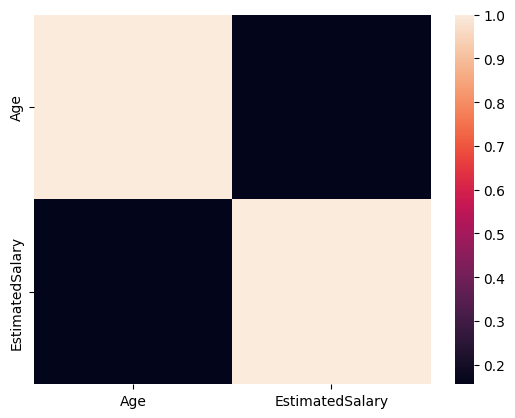

In [8]:
sns.heatmap(data.loc[:,['Age','EstimatedSalary']].corr(method = "pearson"))
plt.show()

In [9]:
data.loc[:,['Age','EstimatedSalary']].corr(method = "pearson")
#Pearson: El coeficiente de correlación de Pearson mide la relación lineal entre dos conjuntos de datos. Los valores varían entre -1 y 1, donde 1 indica una correlación perfecta positiva, -1 indica una correlación perfecta negativa y 0 indica que no hay correlación.

,Age,EstimatedSalary
Age,1.000000,0.155238
EstimatedSalary,0.155238,1.000000


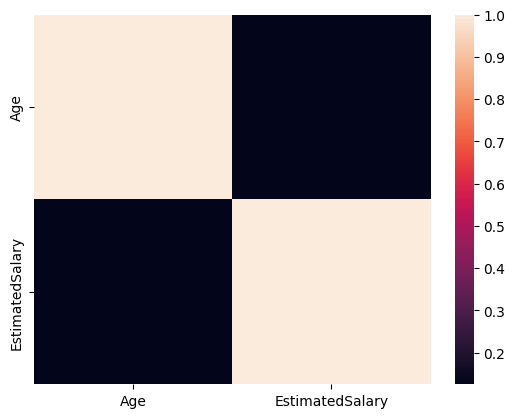

In [10]:
sns.heatmap(data.loc[:,['Age','EstimatedSalary']].corr(method = "spearman"))
plt.show()

In [11]:
data.loc[:,['Age','EstimatedSalary']].corr(method = "spearman")
#Spearman: Esta es una correlación basada en el rango y es más robusta que Pearson. Es útil cuando tus datos no tienen una distribución normal o cuando las relaciones son no lineales.

,Age,EstimatedSalary
Age,1.000000,0.124824
EstimatedSalary,0.124824,1.000000


<Axes: >

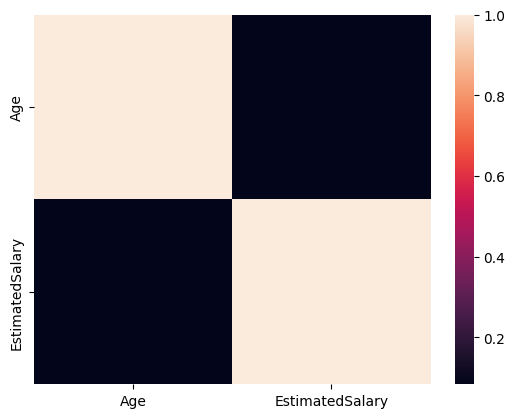

In [12]:
sns.heatmap(data.loc[:,['Age','EstimatedSalary']].corr(method = "kendall"))

In [13]:
data.loc[:,['Age','EstimatedSalary']].corr(method = "kendall")
#Kendall: Este es otro método basado en el rango y es útil en situaciones similares a Spearman, especialmente cuando hay muchas observaciones con valores idénticos.

,Age,EstimatedSalary
Age,1.000000,0.083686
EstimatedSalary,0.083686,1.000000


In [14]:
ss.pearsonr(data['Age'],data['EstimatedSalary'])

PearsonRResult(statistic=0.15523801797210005, pvalue=0.0018460568005798244)

##### Prueba de Correlación
    Ho: no existe correlación entre las variables
    Ha: existe correlación entre las variables

Con un nivel de confianza del 95%, se rechaza la Ho, pues el p-valor < 5%. Se concluye que las variables 'Age' y 'EstimatedSalary' están correlacionadas. Sin embargo, el grado de correlación entre estas variables es de 0.15523801797210005, lo que indica una correlación positiva débil.

In [15]:
data.Purchased.value_counts()

Purchased
0    257
1    143
Name: count, dtype: int64

In [16]:
100*data['Purchased'].value_counts(normalize=True)

Purchased
0    64.25
1    35.75
Name: proportion, dtype: float64

In [17]:
X = data.iloc[:, [2, 3]].values
y = data.iloc[:, -1].values
X.shape, y.shape

((400, 2), (400,))

In [18]:
X[:5], y[:5]

(array([[   19, 19000],
        [   35, 20000],
        [   26, 43000],
        [   27, 57000],
        [   19, 76000]], dtype=int64),
 array([0, 0, 0, 0, 0], dtype=int64))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((320, 2), (80, 2), (320,), (80,))

## Base

In [20]:
X_train_base = sc.fit_transform(X_train)
X_test_base = sc.transform(X_test)
X_train_base[:5],X_train_base.shape, X_test_base[:5],X_test_base.shape

(array([[ 1.92295008,  2.14601566],
        [ 2.02016082,  0.3787193 ],
        [-1.3822153 , -0.4324987 ],
        [-1.18779381, -1.01194013],
        [ 1.92295008, -0.92502392]]),
 (320, 2),
 array([[-0.79895082,  0.49460758],
        [-0.02126485, -0.57735906],
        [-0.31289709,  0.14694273],
        [-0.79895082,  0.26283101],
        [-0.31289709, -0.57735906]]),
 (80, 2))

### KNN

In [21]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_base, y_train)
resultados.append(evaluate_model(knn_classifier, X_test_base, y_test, "KNN_Base"))

### NB

In [22]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_base, y_train)
resultados.append(evaluate_model(nb_classifier, X_test_base, y_test, "Naive Bayes_Base"))

## SMOTE

In [23]:
X_train_smote = sc.fit_transform(X_train)
X_test_smote = sc.transform(X_test)
X_train_smote, y_train_smote = sm.fit_resample(X_train_smote, y_train)
X_train_smote[:5], X_test_smote[:5]

(array([[ 1.92295008,  2.14601566],
        [ 2.02016082,  0.3787193 ],
        [-1.3822153 , -0.4324987 ],
        [-1.18779381, -1.01194013],
        [ 1.92295008, -0.92502392]]),
 array([[-0.79895082,  0.49460758],
        [-0.02126485, -0.57735906],
        [-0.31289709,  0.14694273],
        [-0.79895082,  0.26283101],
        [-0.31289709, -0.57735906]]))

### KNN

In [24]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_smote, y_train_smote)
resultados.append(evaluate_model(knn_classifier, X_test_smote, y_test, "KNN_SMOTE"))

### NB

In [25]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_smote, y_train_smote)
resultados.append(evaluate_model(nb_classifier, X_test_smote, y_test, "Naive Bayes_SMOTE"))

## Oversampling

In [26]:
X_train_oversamplig, y_train_oversampling = ros.fit_resample(X_train, y_train)
X_train_oversamplig = sc.fit_transform(X_train_oversamplig)
X_test_oversamplig = sc.transform(X_test)
X_train_oversamplig[:5], X_test_oversamplig[:5]

(array([[ 1.73037769,  1.92447974],
        [ 1.82586997,  0.26051311],
        [-1.51635982, -0.50327486],
        [-1.32537526, -1.04883769],
        [ 1.73037769, -0.96700327]]),
 array([[-0.94340614,  0.36962567],
        [-0.1794679 , -0.63966557],
        [-0.46594474,  0.04228797],
        [-0.94340614,  0.15140054],
        [-0.46594474, -0.63966557]]))

In [27]:
print(Counter(y_train))
print(Counter(y_train_oversampling))

Counter({0: 199, 1: 121})
Counter({1: 199, 0: 199})


### KNN

In [28]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_oversamplig, y_train_oversampling)
resultados.append(evaluate_model(knn_classifier, X_test_oversamplig, y_test, "KNN_Oversampling"))

### NB

In [29]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_oversamplig, y_train_oversampling)
resultados.append(evaluate_model(nb_classifier, X_test_oversamplig, y_test, "Naive Bayes_Oversampling"))

## Undersampling

In [30]:
X_train_undersampling, y_train_undersampling = rus.fit_resample(X_train, y_train)
X_train_undersampling = sc.fit_transform(X_train_undersampling)
X_test_undersampling = sc.transform(X_test)
X_train_undersampling[:5], X_test_undersampling[:5]

(array([[ 0.84819542, -0.24784723],
        [-1.40206945, -1.16589362],
        [-0.22801821, -0.08092971],
        [-0.13018061, -0.08092971],
        [-0.22801821, -0.52604311]]),
 array([[-1.01071904,  0.36418369],
        [-0.22801821, -0.66514105],
        [-0.52153102,  0.03034864],
        [-1.01071904,  0.14162699],
        [-0.52153102, -0.66514105]]))

In [32]:
print(Counter(y_train))
print(Counter(y_train_undersampling))

Counter({0: 199, 1: 121})
Counter({0: 121, 1: 121})


### KNN

In [33]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_undersampling, y_train_undersampling)
resultados.append(evaluate_model(knn_classifier, X_test_undersampling, y_test, "KNN_Undersampling"))

### NB

In [34]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_undersampling, y_train_undersampling)
resultados.append(evaluate_model(nb_classifier, X_test_oversamplig, y_test, "Naive Bayes_Oversampling"))

## Guardamos resultados

In [40]:
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

                     Modelo  Sensibilidad       ROC      GINI
0                  KNN_Base      0.954545  0.990596  0.981191
1          Naive Bayes_Base      0.818182  0.984326  0.968652
2                 KNN_SMOTE      0.954545  0.989028  0.978056
3         Naive Bayes_SMOTE      0.909091  0.984326  0.968652
4          KNN_Oversampling      0.954545  0.977665  0.955329
5  Naive Bayes_Oversampling      0.909091  0.984326  0.968652
6         KNN_Undersampling      0.954545  0.979232  0.958464
7  Naive Bayes_Oversampling      0.954545  0.984326  0.968652


El modelo "KNN_Base" tiene las métricas más altas en las tres categorías(Sensibilidad,ROC, GINI), por lo que podría considerarse el "mejor" basándonos en esos criterios.

In [41]:
df_resultados.to_csv("resultados_modelos.csv", index=False)

# Segunda Parte

        Modelo  Sensibilidad       ROC      GINI
0  Naive Bayes      0.818182  0.984326  0.968652
1          KNN      0.954545  0.990596  0.981191
2  Naive Bayes      0.818182  0.984326  0.968652
3          KNN      0.954545  0.990596  0.981191
4  Naive Bayes      0.818182  0.984326  0.968652
5          KNN      0.954545  0.990596  0.981191
6          KNN      0.954545  0.990596  0.981191
7  Naive Bayes      0.818182  0.984326  0.968652


In [39]:
data

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


In [38]:
y_train

array([1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,

In [37]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1], dtype=int64)

In [ ]:
# Obtener las probabilidades predichas para la clase 1
y_prob = classifier.predict_proba(X_test)[:, 1]